In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [4]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [5]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [6]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [7]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [8]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', creation_date)::DATE month_date,
       SUM(views_count) total_views
FROM stackoverflow.posts
WHERE EXTRACT(YEAR FROM creation_date) = 2008
GROUP BY DATE_TRUNC('month', creation_date)::DATE
ORDER BY SUM(views_count) DESC 
'''
# выполните запрос

In [9]:
views_df = pd.read_sql_query(query, con=engine)
views_df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

In [10]:
import seaborn as sns

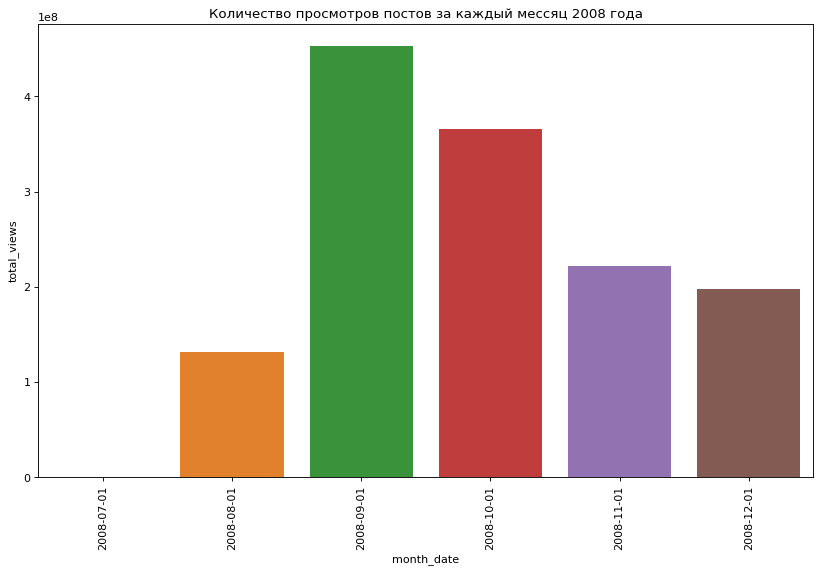

In [11]:
views_df = views_df.sort_values(by='month_date')

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (1000 / dpi, 600 / dpi) )
sns.barplot(x='month_date', y='total_views', data=views_df, color='pink')
plt.xticks(rotation=90)
plt.title('Количество просмотров постов за каждый мессяц 2008 года')
plt.show()

**Ответ:**  

Данные о количествах просмотров постов в 2008 году имеются только за период с июля. Можно предположить, что это момент основания социальной сети, и данные только начали агрегироваться. В сентябре наблюдается пик просмотров, это может быть связано с тем, что в сентябре вышли наиболее популярные посты с частозадаваемыми вопросами. Далее показатель идет на убыль, т.к. темы выходящих постов могут иметь наиболее узкую специфику для решения более сложных задач в программировании.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [12]:
# напишите запрос
query = '''
WITH selected AS (
    SELECT u.display_name,
           u.id,
           u.creation_date registration_date,
           ps.creation_date post_date,
           u.creation_date + INTERVAL'1 months' interval_date
    FROM stackoverflow.posts ps
    JOIN stackoverflow.users u ON u.id=ps.user_id
    WHERE ps.parent_id != 0),

activity_users AS(
    SELECT DISTINCT *
    FROM (SELECT *,
                 COUNT(*) OVER(PARTITION BY id) answers
          FROM selected
          WHERE post_date < interval_date) sl
    WHERE answers > 100
    ORDER BY answers DESC)
    
SELECT display_name,
       COUNT(DISTINCT id)
FROM activity_users
GROUP BY display_name
ORDER BY display_name
'''

# выполните запрос

In [13]:
act_users = pd.read_sql_query(query, con=engine)
act_users

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Amy B,1
...,...,...
57,leppie,1
58,lomaxx,1
59,mattlant,1
60,paxdiablo,1


Какие аномалии наблюдаются в данных? О чём они говорят?

Самое большое число ответов в количестве 379 в первый месяц после регистрации дал пользователь под именем `Jon Skeet`. Дата его регистрации приходится на сентябрь 2008г. - месяц с самыми популярными вопросами. Можно предположить, что `Jon Skeet` - сотрудник соц сети. Расчеты представлены ниже:

In [14]:
act_users['count'].unique()

array([1])

In [15]:
act_users['display_name'].unique()

array(['1800 INFORMATION', 'Adam Bellaire', 'Adam Davis', 'Adam Liss',
       'Amy B', 'Ben Hoffstein', 'Cade Roux', 'CesarB',
       'ConcernedOfTunbridgeWells', 'Dale Ragan', 'Dan', 'Eric Z Beard',
       'Espo', 'FlySwat', 'Franci Penov', 'GEOCHET', 'GateKiller', 'Greg',
       'Gulzar Nazim', 'Ilya Kochetov', 'James Curran', 'Joe',
       'Joel Coehoorn', 'Johannes Schaub - litb', 'John Millikin',
       'Jon Limjap', 'Jon Skeet', 'Jorge Ferreira', 'Keith', 'Kibbee',
       'Konrad Rudolph', 'Lasse Vågsæther Karlsen', 'Marc Gravell',
       'Mark Cidade', 'Mark Harrison', 'Matt Hamilton', 'Michael Burr',
       'Michael Stum', 'Mitchel Sellers', 'Norman Ramsey', 'Oli',
       'Orion Edwards', 'Paul Nathan', 'PhiLho', 'Rob Cooper',
       'Rob Walker', 'S.Lott', 'Sklivvz', 'Steven A. Lowe', 'TheSmurf',
       'Vilx-', 'Vinko Vrsalovic', 'aku', 'anjanb', 'dkretz',
       'frankodwyer', 'gbjbaanb', 'leppie', 'lomaxx', 'mattlant',
       'paxdiablo', 'tzot'], dtype=object)

In [16]:
# напишите запрос
query1 = '''
WITH selected AS (
    SELECT u.display_name,
           u.id,
           u.creation_date registration_date,
           ps.creation_date post_date,
           u.creation_date + INTERVAL'1 months' interval_date
    FROM stackoverflow.posts ps
    JOIN stackoverflow.users u ON u.id=ps.user_id
    WHERE ps.parent_id != 0)


SELECT *,
       COUNT(*) OVER(PARTITION BY id) answers
FROM selected
WHERE post_date < interval_date
    

'''

# выполните запрос

In [17]:
act_user = pd.read_sql_query(query1, con=engine)
act_user

,display_name,id,registration_date,post_date,interval_date,answers
0,Jeff Atwood,1,2008-07-31 14:22:31,2008-08-12 00:30:43,2008-08-31 14:22:31,25
1,Jeff Atwood,1,2008-07-31 14:22:31,2008-08-28 13:26:28,2008-08-31 14:22:31,25
2,Jeff Atwood,1,2008-07-31 14:22:31,2008-08-04 08:04:42,2008-08-31 14:22:31,25
3,Jeff Atwood,1,2008-07-31 14:22:31,2008-08-12 23:13:41,2008-08-31 14:22:31,25
4,Jeff Atwood,1,2008-07-31 14:22:31,2008-08-25 00:11:44,2008-08-31 14:22:31,25
...,...,...,...,...,...,...
110391,Tom H,5696608,2008-09-17 14:15:24,2008-09-23 14:38:48,2008-10-17 14:15:24,34
110392,Tom H,5696608,2008-09-17 14:15:24,2008-09-24 20:18:37,2008-10-17 14:15:24,34
110393,Tom H,5696608,2008-09-17 14:15:24,2008-09-17 16:50:28,2008-10-17 14:15:24,34
110394,Tom H,5696608,2008-09-17 14:15:24,2008-09-17 16:40:38,2008-10-17 14:15:24,34


<AxesSubplot:>

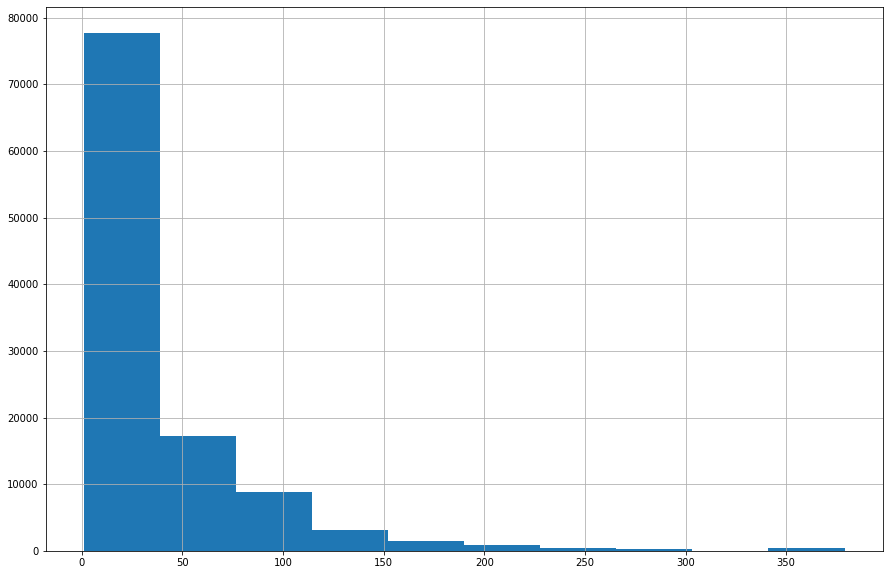

In [18]:
act_user['answers'].hist(figsize=(15,10))

In [19]:
act_user.query('answers > 350')['display_name'].unique()

array(['Jon Skeet'], dtype=object)

In [20]:
act_user.query('display_name == "Jon Skeet"')['registration_date'].unique()

array(['2008-09-26T12:05:05.000000000'], dtype='datetime64[ns]')

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [21]:
# напишите запрос
query = '''

SELECT DATE_TRUNC('month', ps.creation_date)::DATE,
       COUNT(DISTINCT ps.id)
FROM stackoverflow.posts ps
JOIN stackoverflow.users u ON u.id=ps.user_id
WHERE EXTRACT(YEAR FROM ps.creation_date) = 2008
  AND u.id IN (SELECT DISTINCT u.id
               FROM stackoverflow.posts ps
               JOIN stackoverflow.users u ON u.id=ps.user_id
               WHERE DATE_TRUNC('month', ps.creation_date)::DATE = '2008-12-01'
                 AND DATE_TRUNC('month', u.creation_date)::DATE = '2008-09-01')
GROUP BY DATE_TRUNC('month', ps.creation_date)::DATE
ORDER BY DATE_TRUNC('month', ps.creation_date)::DATE DESC
'''

# выполните запрос

In [22]:
posts_2008 = pd.read_sql_query(query, con=engine)
posts_2008

,date_trunc,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

**Ответ** 

Изучив сводную таблицу мы видим, что 32 поста были размещены  в августе 2008 года пользователями, которые зарегистрированы только в сентябре того же года. Можно предположить, что изначально посты можно было публиковать без прохождения регистрации. Изучив этих пользователей более детально, мы увидели что все эти посты были написаны двумя пользователями, основная часть из них пользователем с id 31505. Последняя дата посещения сайта ранее даты регистрации. Так же эти аномалии могли появится из-за пробелов в данных в период начала деятельности компании и пропуски заполняли интуитивно. Так же на это указывает округленное время регистрации `2008-09-01 00:00:00`.

In [23]:
# напишите запрос
query = '''

SELECT *
FROM stackoverflow.posts ps
JOIN stackoverflow.users u ON u.id=ps.user_id
WHERE EXTRACT(YEAR FROM ps.creation_date) = 2008
  AND u.id IN (SELECT DISTINCT u.id
               FROM stackoverflow.posts ps
               JOIN stackoverflow.users u ON u.id=ps.user_id
               WHERE DATE_TRUNC('month', ps.creation_date)::DATE = '2008-12-01'
                 AND DATE_TRUNC('month', u.creation_date)::DATE = '2008-09-01')
  AND DATE_TRUNC('month', ps.creation_date)::DATE = '2008-08-01'
'''

# выполните запрос

In [24]:
posts_08 = pd.read_sql_query(query, con=engine)
posts_08

,id,title,creation_date,favorites_count,last_activity_date,last_edit_date,user_id,parent_id,post_type_id,score,views_count,id,creation_date,display_name,last_access_date,location,reputation,views
0,36034,None,2008-08-30 15:20:15,0,2015-09-08 02:12:15.213,2015-09-08 02:12:15,4381,35988,2,24,0,4381,2008-09-03 10:48:17,Vicent Marti,2013-10-16 02:51:37,None,4142,720
1,36039,Templates spread across multiple files,2008-08-30 15:27:35,1,2008-09-21 23:27:24.657,NaT,4381,0,1,22,11723,4381,2008-09-03 10:48:17,Vicent Marti,2013-10-16 02:51:37,None,4142,720
2,8807,Cannot add WebViewer of ActiveReports to an AS...,2008-08-12 13:15:47,0,2012-08-11 15:32:05.283,2012-08-11 15:32:05,31505,0,1,2,970,31505,2008-09-01 00:00:00,Serhat Ozgel,2018-08-31 14:18:10,"Istanbul, Turkey",13622,2568
3,8876,Evidence Based Scheduling Tool,2008-08-12 14:16:42,8,2013-09-27 20:20:26.243,2013-09-27 20:20:26,31505,0,1,30,2722,31505,2008-09-01 00:00:00,Serhat Ozgel,2018-08-31 14:18:10,"Istanbul, Turkey",13622,2568
4,8899,None,2008-08-12 14:39:20,0,2008-08-12 14:39:20.040,NaT,31505,8807,2,2,0,31505,2008-09-01 00:00:00,Serhat Ozgel,2018-08-31 14:18:10,"Istanbul, Turkey",13622,2568
5,9033,Hidden Features of C#?,2008-08-12 16:32:25,5302,2017-09-25 20:53:48.090,2017-09-25 20:53:48,31505,0,1,1476,618901,31505,2008-09-01 00:00:00,Serhat Ozgel,2018-08-31 14:18:10,"Istanbul, Turkey",13622,2568
6,9049,None,2008-08-12 17:00:35,0,2008-08-12 17:00:35.060,NaT,31505,5916,2,2,0,31505,2008-09-01 00:00:00,Serhat Ozgel,2018-08-31 14:18:10,"Istanbul, Turkey",13622,2568
7,9851,None,2008-08-13 14:03:39,0,2008-08-13 14:11:24.807,2008-08-13 14:11:25,31505,9805,2,6,0,31505,2008-09-01 00:00:00,Serhat Ozgel,2018-08-31 14:18:10,"Istanbul, Turkey",13622,2568
8,10378,None,2008-08-13 21:10:42,0,2016-11-30 10:30:22.153,2016-11-30 10:30:22,31505,10366,2,8,0,31505,2008-09-01 00:00:00,Serhat Ozgel,2018-08-31 14:18:10,"Istanbul, Turkey",13622,2568
9,10866,None,2008-08-14 10:28:43,0,2008-08-14 10:28:43.070,NaT,31505,10860,2,3,0,31505,2008-09-01 00:00:00,Serhat Ozgel,2018-08-31 14:18:10,"Istanbul, Turkey",13622,2568


# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [25]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) cumulative_count
       
FROM stackoverflow.posts
ORDER BY user_id
'''

# выполните запрос

In [26]:
cumulative_count = pd.read_sql_query(query, con=engine)
cumulative_count.head()

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [27]:
# напишите запрос
query = '''
WITH august_posts AS (
    SELECT ps.id post_id,
           u.id user_id,
           ps.creation_date post_date,
           u.creation_date registration_date,
           COUNT(ps.id) OVER (PARTITION BY u.id) cnt
    FROM stackoverflow.posts ps
    JOIN stackoverflow.users u ON u.id=ps.user_id
    WHERE DATE_TRUNC('month', ps.creation_date)::DATE = '2008-08-01'),
    
posts_daily AS (
    SELECT user_id,
           post_date::DATE,
           COUNT(DISTINCT post_id) posts_daily
    FROM august_posts
    WHERE cnt > 120
    GROUP BY 1,2)

SELECT user_id,
       AVG(posts_daily) avg_daily
FROM posts_daily
GROUP BY user_id
ORDER BY AVG(posts_daily)
'''

# выполните запрос

In [28]:
avg_daily = pd.read_sql_query(query, con=engine)
avg_daily

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [39]:
# напишите запрос
query = '''
WITH selected AS(
     SELECT u.id,
            ps.creation_date::DATE,
            COUNT(ps.creation_date::DATE)
     FROM stackoverflow.posts ps
     JOIN stackoverflow.users u ON u.id=ps.user_id
     WHERE ps.creation_date::DATE BETWEEN '2008-12-01' AND '2008-12-07'
     GROUP BY 1,2)

SELECT ROUND(SUM(count_day)/COUNT(user_id), 0)::INT result
FROM (SELECT id user_id,
             COUNT(DISTINCT creation_date) count_day
      FROM selected
      GROUP BY 1) slc
'''

# выполните запрос

In [40]:
result = pd.read_sql_query(query, con=engine)
result

,result
0,2


В период с 1 по 7 декабря 2008 г. пользователи взаимодействовали с платформой в среднем 2 дня.

Проанализируйте итоговую таблицу — какие выводы можно сделать?

In [43]:
# напишите запрос
query = '''
WITH selected AS(
     SELECT u.id,
            ps.creation_date::DATE,
            COUNT(ps.creation_date::DATE)
     FROM stackoverflow.posts ps
     JOIN stackoverflow.users u ON u.id=ps.user_id
     WHERE ps.creation_date::DATE BETWEEN '2008-12-01' AND '2008-12-07'
     GROUP BY 1,2)
     
SELECT id user_id,
       COUNT(DISTINCT creation_date) count_day
FROM selected
GROUP BY 1
'''

# выполните запрос

In [44]:
result1 = pd.read_sql_query(query, con=engine)
result1

,user_id,count_day
0,1,3
1,4,2
2,5,2
3,9,1
4,17,4
...,...,...
3761,2921654,2
3762,3535708,1
3763,3540161,4
3764,3644960,1


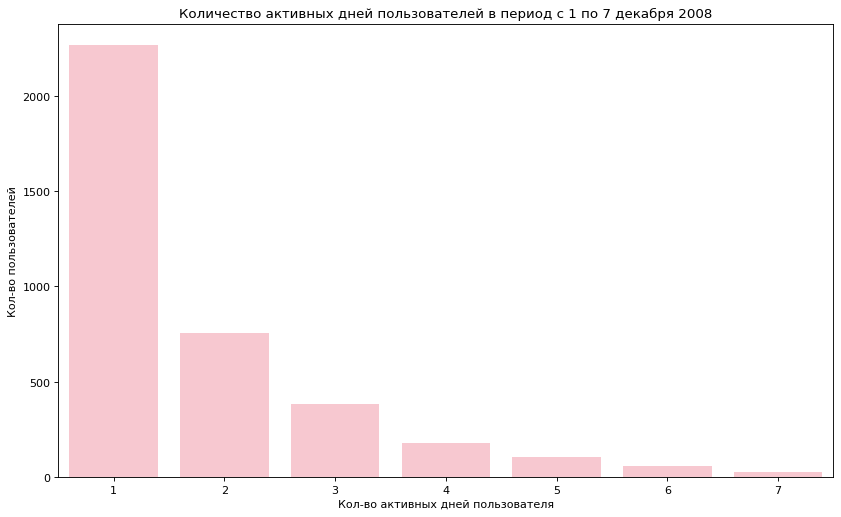

In [46]:
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (1000 / dpi, 600 / dpi) )
ax = sns.countplot(x='count_day', data=result1, color='pink')
plt.title('Количество активных дней пользователей в период с 1 по 7 декабря 2008')
ax.set_ylabel('Кол-во пользователей')
ax.set_xlabel('Кол-во активных дней пользователя')
plt.show()

In [47]:
result1['user_id'].count()

3766

Более половины пользователей проводит в социальной сети только один день из семи. 

In [48]:
# напишите запрос
query = '''

     SELECT u.id,
            ps.creation_date::DATE,
            COUNT(ps.creation_date::DATE)
     FROM stackoverflow.posts ps
     JOIN stackoverflow.users u ON u.id=ps.user_id
     WHERE ps.creation_date::DATE BETWEEN '2008-12-01' AND '2008-12-07'
     GROUP BY 1,2
     

'''

# выполните запрос

In [49]:
result2 = pd.read_sql_query(query, con=engine)
result2

,id,creation_date,count
0,1,2008-12-01,2
1,1,2008-12-03,2
2,1,2008-12-05,1
3,4,2008-12-03,1
4,4,2008-12-06,1
...,...,...,...
6670,5696608,2008-12-01,2
6671,5696608,2008-12-02,2
6672,5696608,2008-12-03,2
6673,5696608,2008-12-04,1


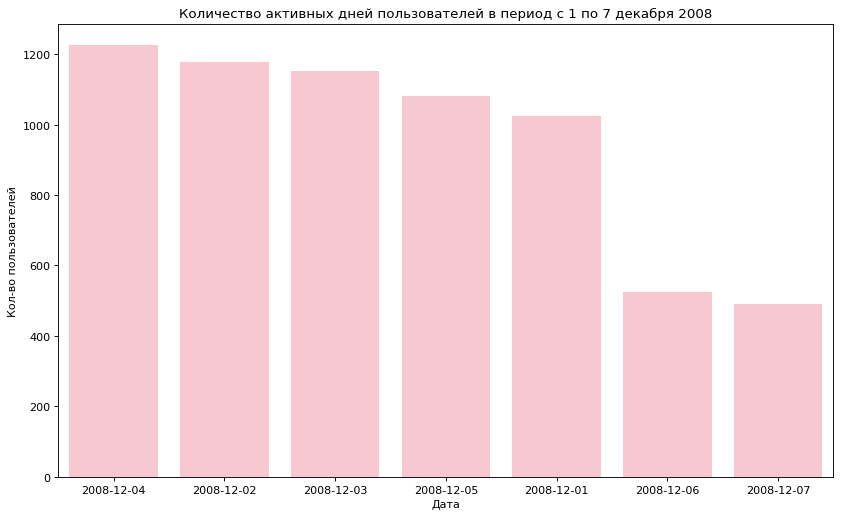

In [52]:
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (1000 / dpi, 600 / dpi) )
ax = sns.countplot(x='creation_date', data=result2, color='pink', order=result2['creation_date'].value_counts().index)
plt.title('Количество активных дней пользователей в период с 1 по 7 декабря 2008')
ax.set_ylabel('Кол-во пользователей')
ax.set_xlabel('Дата')
plt.show()
# напишите ваш ответ здесь

**Вывод** 

В период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой в среднем 2 дня. Стоит отметить, что больше половины пользователей в этот период провели в соц сети только 1 день. Если посмотреть активность пользователей по дням, то можно увидеть, что меньше всего взаимодействий было 6 и 7 декабря, если посмотреть на календарь, видно, что эти дни приходятся на субботу и воскресение. Таким образом, больше всего взаимодействий происходит в рабочие дни.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [53]:
# напишите запрос
query = '''
WITH selected AS (
     SELECT u.id user_id,
            ps.creation_date,
            LAG(EXTRACT(MONTH FROM ps.creation_date), 2) OVER (PARTITION BY u.id ORDER BY ps.creation_date) AS second_last_month
     FROM stackoverflow.posts ps
     JOIN stackoverflow.users u ON u.id=ps.user_id)
     
SELECT user_id,
       creation_date,
       CASE 
          WHEN second_last_month::INT = 1 THEN 'January'
          WHEN second_last_month::INT = 2 THEN 'February'
          WHEN second_last_month::INT = 3 THEN 'March'
          WHEN second_last_month::INT = 4 THEN 'April'
          WHEN second_last_month::INT = 5 THEN 'May'
          WHEN second_last_month::INT = 6 THEN 'June'
          WHEN second_last_month::INT = 7 THEN 'July'
          WHEN second_last_month::INT = 8 THEN 'August'
          WHEN second_last_month::INT = 9 THEN 'September'
          WHEN second_last_month::INT = 10 THEN 'October'
          WHEN second_last_month::INT = 11 THEN 'November'
          WHEN second_last_month::INT = 12 THEN 'December'
        END second_last_month
FROM selected
'''

# выполните запрос

In [54]:
second_last_month = pd.read_sql_query(query, con=engine)
second_last_month.head(10)

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
5,1,2008-08-04 08:04:42,August
6,1,2008-08-10 08:28:52,August
7,1,2008-08-11 19:23:47,August
8,1,2008-08-12 00:30:43,August
9,1,2008-08-12 04:59:35,August


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [55]:
# напишите запрос
query = '''
WITH profile AS(
   SELECT DISTINCT u.id user_id,
          MIN(DATE_TRUNC('month', ps.creation_date)) OVER (PARTITION BY u.id) cohort_dt 
   FROM stackoverflow.posts ps
   JOIN stackoverflow.users u ON u.id=ps.user_id),
   
     profile_2 AS(
   SELECT *,
          COUNT(user_id) OVER (PARTITION BY cohort_dt) cohort_users_cnt
   FROM profile),
   
     sessions AS (
   SELECT u.id user_id,
       DATE_TRUNC('month', ps.creation_date)::DATE session_date
   FROM stackoverflow.posts ps
   JOIN stackoverflow.users u ON u.id=ps.user_id
   GROUP BY 1,2) 
   
SELECT p.cohort_dt,
       s.session_date,
       COUNT(p.user_id) AS users_cnt,
       p.cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / p.cohort_users_cnt, 2) AS retention_rate
FROM profile_2 p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,2,4
'''

# выполните запрос

In [56]:
retention_rate = pd.read_sql_query(query, con=engine)
retention_rate.head(10)

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

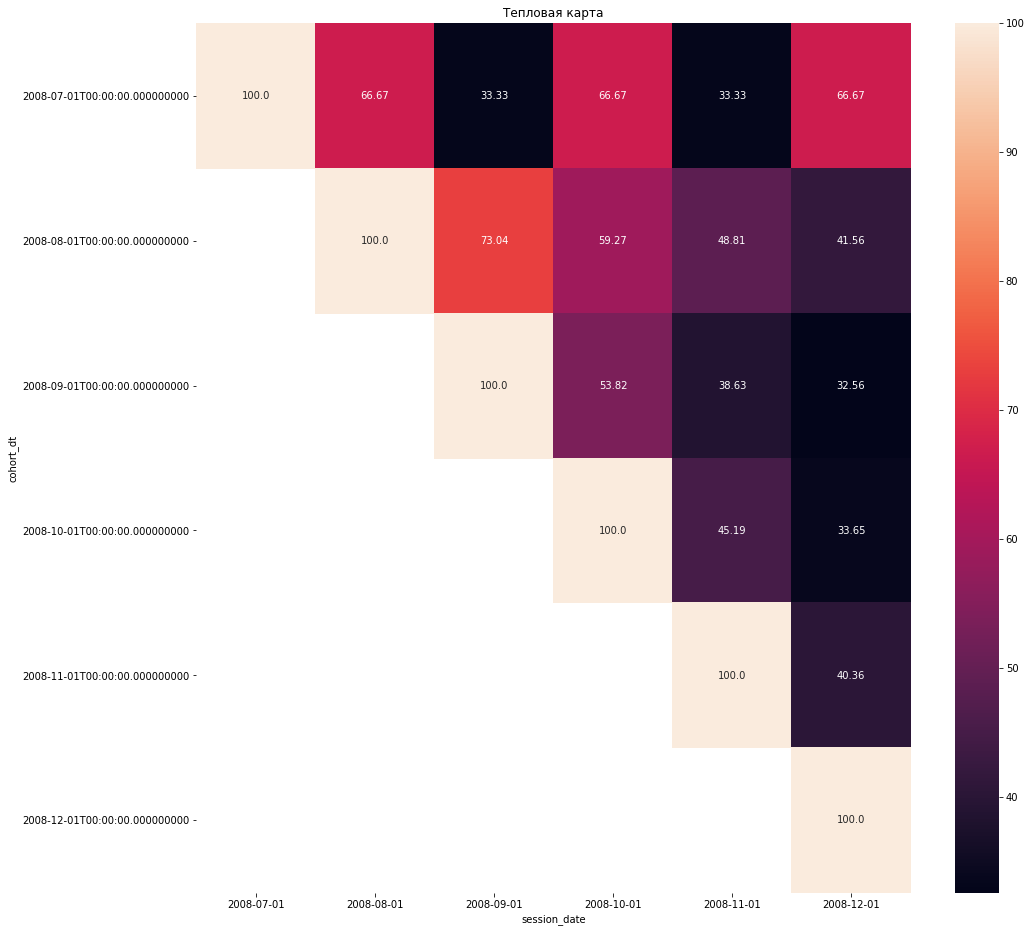

In [59]:
# постройте тепловую карту Retention Rate

retention = retention_rate.pivot('cohort_dt', 'session_date', 'retention_rate')

plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 



**Вывод**

Для когорты, пришедшей в июле 2008 года, удержание меняется с постоянной переодичностью, при этом из месяца в месяц то растет, то снижается. Посмотрев на данную когорту, можно увидеть, что она состоит из трех пользователей, поэтому эту когорту можно исключить из анализа, т.к. на основании такого малого числа наблюдений нельзя делать выводы о тенденциях динамики показателя.

Удержание первого дня для когорты пришедшей в августе самое высокое, среди всех когорт и составляет 73 % от общего числа. Постепенно показатель первого дня снижается, чем позднее пришел пользователь, тем удержание ниже. Та же тенденция снижения и для второго и для третьего дня. Можно предположить, что в августе - в период начала работы системы, пришли проффессиональные участники в сфере IT и программирования, которые вносили наибольший вклад в создание и наполнение данной системы вопросов и ответов о программировании.  

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [60]:
# напишите запрос
query = '''
WITH selected AS(
     SELECT EXTRACT(MONTH FROM creation_date)::INT creation_month,
            COUNT(DISTINCT id) posts_count  
     FROM stackoverflow.posts
     WHERE creation_date::DATE BETWEEN '2008-09-01' AND '2008-12-31'
     GROUP BY 1)
     

SELECT creation_month,
       posts_count,
       ROUND((posts_count - difference)*100.0/difference, 2) percentage
       
FROM (SELECT *,
             LAG(posts_count) OVER () difference
      FROM selected) sl

'''

# выполните запрос

In [61]:
percentage = pd.read_sql_query(query, con=engine)
percentage.head(10)

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

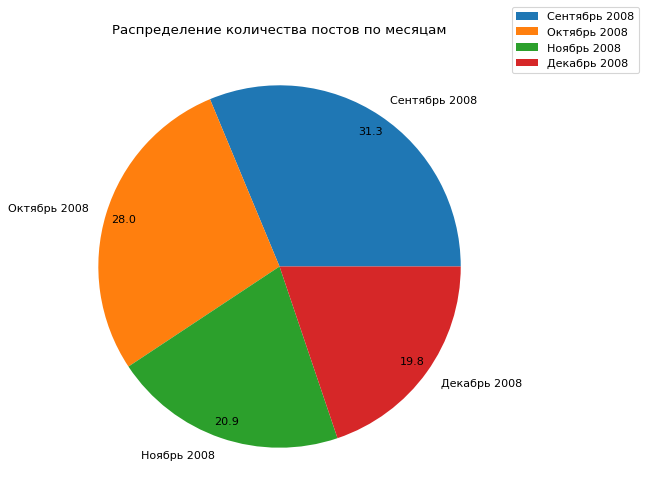

In [64]:
# постройте круговую диаграмму с количеством постов по месяцам

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (1000 / dpi, 600 / dpi) )


plt.title('Распределение количества постов по месяцам')

plt.pie(percentage['posts_count'], labels=['Сентябрь 2008','Октябрь 2008','Ноябрь 2008','Декабрь 2008'], autopct='%.1f', pctdistance=0.9)
plt.legend(loc=6, bbox_to_anchor=(1.0, 1.0))
plt.show()

Начиная с сентября 2008 года количество постов постепенно снижается. Темпы снижения меняются из месяца в месяц то в большую, то в меньшую сторону. Наибольший спад количества опубликованных постов пришелся с октября на ноябрь. Показатель упал на 25 %.

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [65]:
# напишите запрос
query = '''
WITH users AS (
     SELECT user_id,
            COUNT(id)
     FROM stackoverflow.posts
     GROUP BY 1
     ORDER BY COUNT(id) DESC
     LIMIT 1)
     
SELECT DISTINCT EXTRACT(WEEK FROM creation_date)::INT week_creation,
       MAX(creation_date) OVER (PARTITION BY EXTRACT(WEEK FROM creation_date))
FROM stackoverflow.posts
WHERE user_id in (SELECT user_id
                  FROM users)
  AND DATE_TRUNC('month', creation_date)::DATE = '2008-10-01'
'''

# выполните запрос

In [66]:
week_creation = pd.read_sql_query(query, con=engine)
week_creation

,week_creation,max
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
